In [34]:
import cobra
import pandas as pd
import seaborn as sb
from util.manipulation import load_latest_model
import numpy as np
import matplotlib.pyplot as plt
from os import path

### Tutorial 3: Comparing with experimental data

In this tutorial, we will compare the model predictions to experimental data. The validation of the predictions is an indicator of the reliability of a model. As we should always see things on the bright side, the predictions that were not validated by the model are opportunities to learn new biology, remember that no model is perfect but some are useful. We will compare the following model predictions with experimental data:

    1- Gene essentiality
    2- Flux states vs gene expression
    3- Metabolic capabilities

In [3]:
#Load the model
model = load_latest_model()

### 1- Compare essentiality predictions with experimental data

In [6]:
#Load the essentiality data
essentiality_data = pd.read_csv(path.join('../data','Mflorum_essentiality.csv'), index_col=0)

In [12]:
essentiality_data.columns

Index(['Genes', 'Essentiality'], dtype='object')

In [22]:
#Compare single gene essentiality predictions with essentiality data
#1- Generate single gene essentiality prediction
from cobra.flux_analysis import single_gene_deletion
essentiality_prediction_raw = single_gene_deletion(model)
#Modify the dataframe to make it useful
genes, essentiality = [],[]
growth_threshold = model.slim_optimize() * 0.5
for i,row in essentiality_prediction_raw.iterrows():
    genes.append(list(i)[0])
    if row['growth'] < growth_threshold:
        essentiality.append('E')
    elif row['growth'] >= growth_threshold:
        essentiality.append('NE')
    else:
        essentiality.append('E')
#Put the info in a dataframe      
essentiality_prediction = pd.DataFrame({'Genes':genes,'Essentiality':essentiality})

In [25]:
#2- Compare experimental essentiality to predictions
essentiality_comparison = pd.merge(left=essentiality_data,right=essentiality_prediction, on='Genes',suffixes=('_experimental','_predicted'))

In [29]:
#3- Replace E and NE with 1 and 0 for ploting
essentiality_comparison.replace(to_replace=['E','NE'],value=[1,0],inplace=True)

In [32]:
essentiality_comparison.index = essentiality_comparison.Genes.to_list()
del essentiality_comparison['Genes']

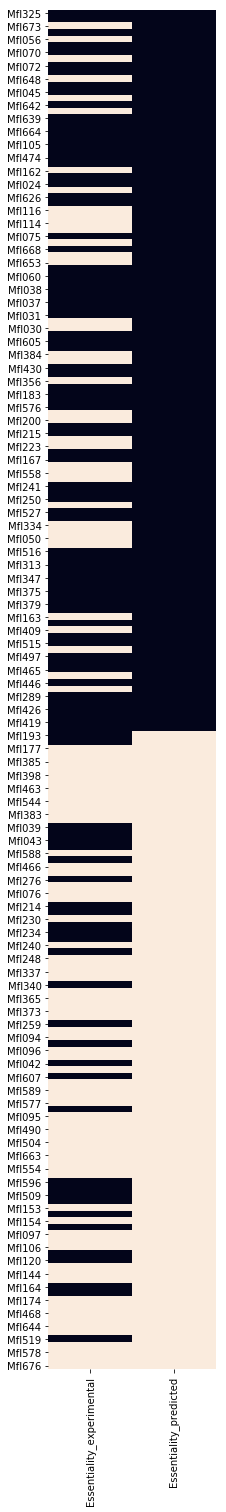

In [41]:
essentiality_comparison.sort_values('Essentiality_predicted',inplace=True)
fig = plt.figure(figsize=(3,25))
ax = fig.add_subplot(111)
sb.heatmap(essentiality_comparison,cbar=False,ax=ax)

In [43]:
#4- Get the number of true positive, true negative, false positive, false negatives
true_positives = essentiality_comparison[(essentiality_comparison['Essentiality_experimental'] == 0) &\
                                        (essentiality_comparison['Essentiality_predicted'] == 0)]
len(true_positives)

73

In [45]:
#5- Now calculate true negatives

#true_negatives = ...

In [46]:
#6- Now calculate false positives

#false_positives = ...

In [47]:
#7- Now calculate false negatives

#false_negatives = ...

In [48]:
#8- Get the % of accuracy (total of true predictions compared to total predictions)
# accuracy = ((len(true_positives) + len(true_negatives)) / len(model.genes)) * 100

### 2- Compare gene expression data with experimental gene expression

In [81]:
#Pre-processing of data to yield the csv file used in this tutorial
# #Read excel file
# supp_data_from_dom = pd.read_excel('../../Mmodel_paper/Supplementary_files/DatasetS7_v2.0.xlsx')
# #Extract only two columns
# proteomic_raw = supp_data_from_dom[['gene name (RefSeq)','number of protein molecules']]
# #Remove first row
# proteomic_raw = proteomic_raw[1:]
# #Change column names
# proteomic_raw.rename(columns={"gene name (RefSeq)": "Genes", "number of protein molecules": "protein_count"},inplace=True)
# #Remove NAN values (genes that had no match between rast and refseq)
# proteomic_raw.dropna(how='any',axis=0,inplace=True)
# #Capitalize all in the Genes column
# proteomic_raw['Genes'] = proteomic_raw['Genes'].str.capitalize()
# #Save to csv
# proteomic_raw.to_csv('../data/Mflorum_proteomic.csv')

In [93]:
#0- Load the expression data
proteomic_data = pd.read_csv('../data/Mflorum_proteomic.csv', index_col=0)
transcriptomic_data = pd.read_csv('../data/Mflorum_transcriptomic.csv', index_col=0)

In [86]:
proteomic_data.columns, transcriptomic_data.columns

(Index(['Genes', 'protein_count'], dtype='object'),
 Index(['Gene', 'Abundance'], dtype='object'))

In [ ]:
proteomic_data.applymap(lambda x: if x> proteomic_threshold )

In [116]:
#Filter the data to get only the genes where both transcriptomic and proteomic agree
#this has been determined at 
proteomic_threshold = 23
transcriptomic_threshold = 168
#Apply the threshold to determine expressed and non-expressed genes
proteomic_expression = []
for i,row in proteomic_data.iterrows():
    if row['protein_count'] > proteomic_threshold:
        proteomic_expression.append({'Genes':row['Genes'], 'Expression_protein':1})
    else:
        proteomic_expression.append({'Genes':row['Genes'], 'Expression_protein':0})
        
proteomic_expression = pd.DataFrame(proteomic_expression)

transcriptomic_expression = []
for i,row in transcriptomic_data.iterrows():
    if row['Abundance'] > transcriptomic_threshold:
        transcriptomic_expression.append({'Genes':row['Gene'], 'Expression_rna':1})
    else:
        transcriptomic_expression.append({'Genes':row['Gene'], 'Expression_rna':0})
        
transcriptomic_expression = pd.DataFrame(transcriptomic_expression)

In [117]:
#Merge
all_expression = pd.merge(left=transcriptomic_expression, right=proteomic_expression,on='Genes')
# all_expression.index = all_expression['Genes'].to_list()
# del all_expression['Genes']

In [118]:
#Get the expression that is consistent amongst both
consistent_expression = all_expression[all_expression['Expression_rna'] == all_expression['Expression_protein']]

In [102]:
#Display the number of genes that have a consistent expression at the given threshold
#print(...)

In [120]:
#Now compare with model predictions
def generate_predictions(model):
    from cobra.flux_analysis import pfba
    #Run pFBA
    pfba_solution = pfba(model)
    #Get more info on current active fluxes predictions
    fluxes = pfba_solution.fluxes
    #Associate the pFBA reaction fluxes to the genes that catalyze them
    gene_list,flux_list = [],[]
    for k,v in pfba_solution.fluxes.items():
        react = model.reactions.get_by_id(k)
        GPR = react.genes
        for gene in GPR:
            gene_list.append(gene.id)
            flux_list.append(v)
    df_pFBA_flux_gene = pd.DataFrame({'Genes':gene_list,'Flux':flux_list})
    output_df = df_pFBA_flux_gene.groupby('Genes').agg(lambda x: np.average(x))

    unique_genes,unique_flux = [],[]
    for i,row in output_df.iterrows():
        unique_genes.append(i)
        unique_flux.append(row.Flux)
    df_pFBA_genes = pd.DataFrame({'Genes':unique_genes,'Flux':unique_flux},
                              columns=['Genes','Flux'])
    #Convert fluxes to binary
    flux_status = []
    for i,row in df_pFBA_genes.iterrows():
        if abs(row['Flux']) > 1e-8:
            flux_status.append(1)
        else:
            flux_status.append(0)
    del df_pFBA_genes['Flux']
    df_pFBA_genes['Flux'] = flux_status
    
    return df_pFBA_genes

pFBA_predictions = generate_predictions(model)

In [122]:
#Merge the observations with the predictions
model_expression_comparison = pd.merge(left=pFBA_predictions, right=consistent_expression, on='Genes',how='inner')

In [123]:
#Get the number of genes with consistent expression data in the model
#print(...)

In [124]:
#Plot the heatmap
#sb.heatmap(...)

In [125]:
#Get the TP, TN, FP, FN